# Merge/split analysis

See [merge_split_experiments](merge_split_experiments.ipynb) for inital dev work. From that, I worked out a few things to do with how merges/splits work, summarized here.

1. Clouds smaller than MCSs can be merged/split into an MCS. This is what e.g. the `dstracks.merge_cloudnumber` fields tracks. Likewise, this info is in the `dspixel` data.
2. MCSs can merge split, if the clouds (as above) are large enough to fulfil the MCS criteria.
3. The information about which MCS a daughter MCS split from (or merges into) can be obtained from the `dstracks` data.

Here, I'm going to do some nicer analysis that demonstrates the above for sharing with other people.

* 13/6/22: Initial work

## Analysis 1 (merge/split clouds)

In [ ]:
import datetime as dt
import itertools
from pathlib import Path

import cartopy.crs as ccrs
import dask
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml"
import matplotlib.animation
import numpy as np
import pandas as pd
from scipy import stats
from scipy import interpolate
import xarray as xr

from mcs_prime import McsTracks, McsTrack, PATHS
from mcs_prime.util import update_progress
# %matplotlib inline

Load all tracks from 2000/6-2020/12

In [ ]:
tracks = McsTracks.load(PATHS['statsdir'] / 'mcs_tracks_final_extc_20190101.0000_20200101.0000.nc', 
                                 PATHS['pixeldir'])

In [ ]:
ntracks = len(tracks.dstracks.tracks)

print('start split:', (tracks.dstracks.start_split_cloudnumber > 0).sum().values.item() / ntracks)
print('end merge  :', (tracks.dstracks.end_merge_cloudnumber > 0).sum().values.item() / ntracks)
print('either     :', ((tracks.dstracks.start_split_cloudnumber > 0).values | (tracks.dstracks.end_merge_cloudnumber > 0).values).sum() / ntracks)

In [ ]:
tracks = tracks.tracks_at_time(dt.datetime(2019, 6, 10, 0, 30))
tracks

In [ ]:
dstrack = tracks.dstracks.isel(tracks=(tracks.dstracks.track_duration > 20) & (tracks.dstracks.track_duration < 40)).isel(tracks=0)
track = McsTrack(dstrack.tracks.values.item(), dstrack, tracks.pixel_data)


# track = tracks.get_track(15477)
# track = tracks.get_track(298)
# track = tracks.get_track(1234)
track

In [ ]:
start = pd.Timestamp(track.dstrack.start_basetime.values).to_pydatetime()
end = pd.Timestamp(track.dstrack.end_basetime.values).to_pydatetime()

In [ ]:
frames = tracks.pixel_data.get_frames(start, end)

In [ ]:
frames.dspixel.cloudnumber.load()
swath_extent = frames.get_min_max_lon_lat(track.cloudnumber)

In [ ]:
def plot_cloud_merge_split(i):
    cn = track.cloudnumber[i]
    ax.clear()
    ax.contour(frames.dspixel.lon, frames.dspixel.lat, frames.dspixel.cloudnumber[i] == cn, levels=[0.5], colors=['k'])
    ax.set_xlim(swath_extent[:2] + np.array([-2, 2]))
    ax.set_ylim(swath_extent[2:] + np.array([-2, 2]))
    
    mcn = set(v for v in track.dstrack.merge_cloudnumber.values[i] if ~np.isnan(v))
    scn = set(v for v in track.dstrack.split_cloudnumber.values[i] if ~np.isnan(v))
    for cn in mcn & scn:
        ax.contour(frames.dspixel.lon, frames.dspixel.lat, frames.dspixel.cloudnumber[i] == cn, levels=[0.5], colors=['purple'])
    for cn in mcn - scn:
        ax.contour(frames.dspixel.lon, frames.dspixel.lat, frames.dspixel.cloudnumber[i] == cn, levels=[0.5], colors=['g'])
    for cn in scn - mcn:
        ax.contour(frames.dspixel.lon, frames.dspixel.lat, frames.dspixel.cloudnumber[i] == cn, levels=[0.5], colors=['r'])


In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))

In [ ]:
anim = matplotlib.animation.FuncAnimation(fig, plot_cloud_merge_split, frames=track.duration, interval=500)
anim

In [9]:
def contour(ax, f, c, offset=0):
    ax.contour(f.lon, f.lat + offset, f > 0, levels=[0.5], colors=[c])

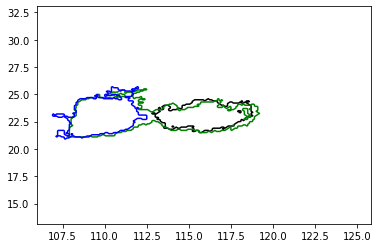

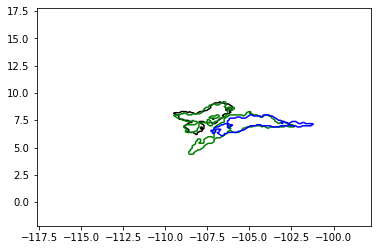

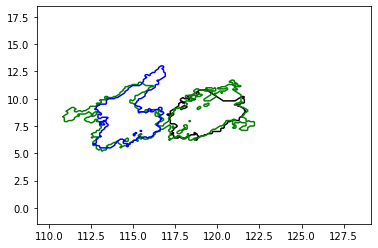

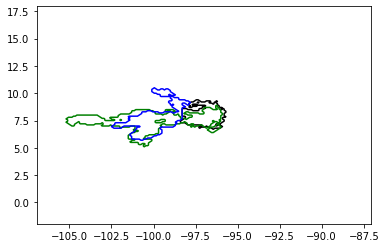

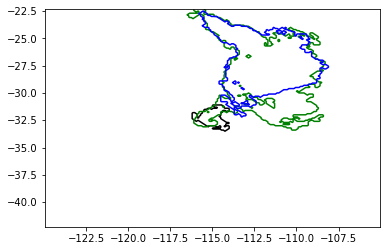

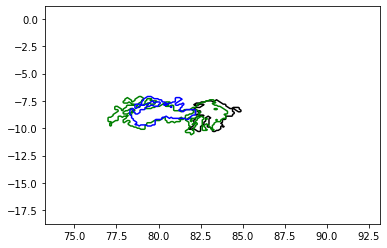

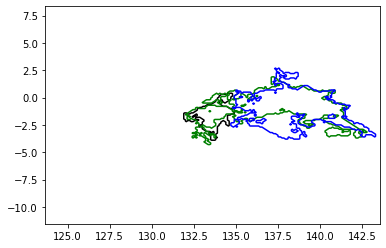

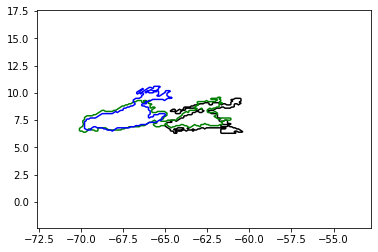

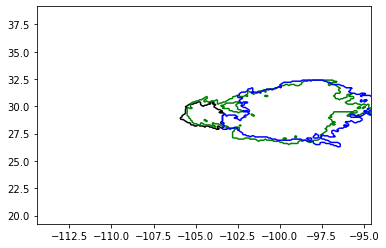

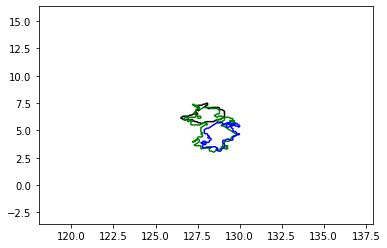

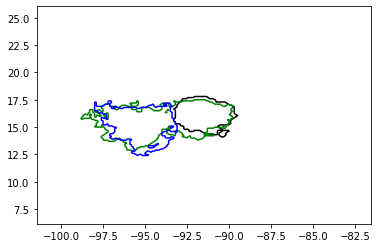

In [31]:
for trackid in tracks.dstracks.isel(tracks=tracks.dstracks.end_merge_cloudnumber > 0).tracks:
    t = tracks.get_track(trackid)
    # print(t)
    time = pd.Timestamp(t.base_time[-1]).to_pydatetime()
    lon = t.meanlon[-1]
    lat = t.meanlat[-1]

    f0 = tracks.pixel_data.get_frame(time)
    f1 = tracks.pixel_data.get_frame(time + dt.timedelta(hours=1))
    subds0 = f0.dspixel.sel(lat=slice(lat - 10, lat + 10), lon=slice(lon - 10, lon + 10)).isel(time=0)
    subds1 = f1.dspixel.sel(lat=slice(lat - 10, lat + 10), lon=slice(lon - 10, lon + 10)).isel(time=0)

    # fig, ax = plt.subplots()

    # contour(ax, subds0.cloudnumber > 0, 'purple')
    # contour(ax, subds0.cloudnumber == t.cloudnumber[-1], 'k')
    # contour(ax, subds1.cloudnumber == t.dstrack.end_merge_cloudnumber, 'g')
    emcn = t.dstrack.end_merge_cloudnumber.values.item()
    found_next_tracks = ((tracks.dstracks.cloudnumber == emcn) & (tracks.dstracks.base_time == t.base_time[-1] + int(3600e9))).sum().values.item()
    if found_next_tracks == 1:
        fig, ax = plt.subplots()

        # contour(ax, subds0.cloudnumber > 0, 'purple')
        contour(ax, subds0.cloudnumber == t.cloudnumber[-1], 'k')
        contour(ax, subds1.cloudnumber == t.dstrack.end_merge_cloudnumber, 'g')

        ds_next_track = tracks.dstracks.isel(
            tracks=((tracks.dstracks.cloudnumber == emcn) & 
                    (tracks.dstracks.base_time == t.base_time[-1] + int(3600e9))).any(axis=1)
        ).isel(tracks=0)
        next_track = McsTrack(ds_next_track.tracks.values.item(), ds_next_track, tracks.pixel_data)
        time_index = next_track.base_time == t.base_time[-1]
        contour(ax, subds0.cloudnumber == next_track.cloudnumber[time_index], 'b')


In [23]:
found_prev_tracks

1

In [24]:
sscn

3.0

In [25]:
t.dstrack.start_split_cloudnumber

<xarray.DataArray 'start_split_cloudnumber' ()>
array(3.)
Coordinates:
    tracks   int64 14335
Attributes:
    long_name:  Cloud number where this track splits from
    units:      unitless

In [37]:
pt = tracks.dstracks.isel(tracks=((tracks.dstracks.cloudnumber == sscn) & (tracks.dstracks.base_time == t.base_time[0] - int(3600e9))).any(axis=1)).isel(tracks=0)
pt = McsTrack(pt.tracks.values.item(), pt, tracks.pixel_data)


In [57]:
t

McsTrack[2019-06-09 10:30:00, 2019-06-10 02:30:00, id=<xarray.DataArray 'tracks' ()>
array(14335)
Coordinates:
    tracks   int64 14335, duration=17]

In [38]:
pt

McsTrack[2019-06-08 21:30:00, 2019-06-10 13:30:00, id=14284, duration=41]

(-62.148170471191406, -17.148170471191406)

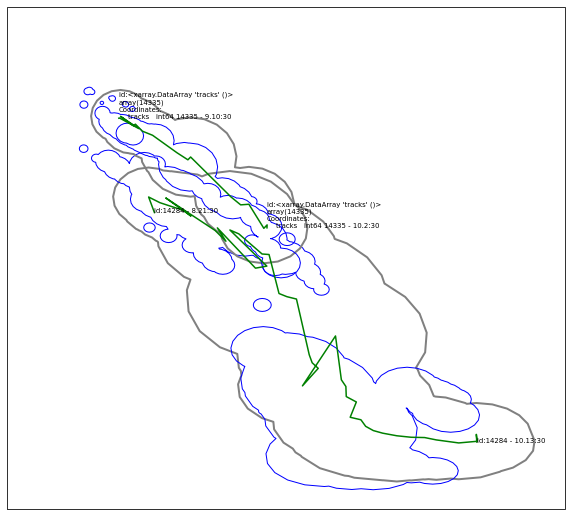

In [56]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches((10, 10))
pt.plot(ax=ax)
t.plot(ax=ax)
ax.set_xlim((t.meanlon[0] - 10, t.meanlon[0] + 40))
ax.set_ylim((t.meanlat[0] - 35, t.meanlat[0] + 10))

In [37]:
tracks = McsTracks.load(PATHS['statsdir'] / 'mcs_tracks_final_extc_20190101.0000_20200101.0000.nc', 
                        PATHS['pixeldir'])

In [59]:
merges_splits = {
    'merge': [],
    'split': [],
    'either': [],
}

tracks.dstracks.cloudnumber.load()
tracks.dstracks.start_split_cloudnumber.load()
tracks.dstracks.end_merge_cloudnumber.load()
tracks.dstracks.base_time.load()

for trackid in tracks.dstracks.tracks.values:
    if trackid % 1000 == 0:
        print(f'{trackid / len(tracks.dstracks.tracks) * 100:.1f}%')
    # print(trackid)
    track = tracks.get_track(trackid)
    
    found_prev_tracks = 0
    found_next_tracks = 0
    if track.dstrack.start_split_cloudnumber > 0:
        sscn = track.dstrack.start_split_cloudnumber.values.item()
        found_prev_tracks = ((tracks.dstracks.cloudnumber == sscn) & (tracks.dstracks.base_time == track.base_time[0] - int(3600e9))).sum().values.item()
    if track.dstrack.end_merge_cloudnumber > 0:    
        emcn = track.dstrack.end_merge_cloudnumber.values.item()
        found_next_tracks = ((tracks.dstracks.cloudnumber == emcn) & (tracks.dstracks.base_time == track.base_time[-1] + int(3600e9))).sum().values.item()
    if found_prev_tracks or found_next_tracks:
        merges_splits['either'].append(trackid)
    if found_prev_tracks:
        merges_splits['split'].append(trackid)
    if found_next_tracks:
        merges_splits['merge'].append(trackid)


0.0%
3.0%
6.1%
9.1%
12.2%
15.2%
18.3%
21.3%
24.4%
27.4%
30.4%
33.5%
36.5%
39.6%
42.6%
45.7%
48.7%
51.8%
54.8%
57.9%
60.9%
63.9%
67.0%
70.0%
73.1%
76.1%
79.2%
82.2%
85.3%
88.3%
91.3%
94.4%
97.4%


In [60]:
print(len(merges_splits['merge']) / ntracks)
print(len(merges_splits['split']) / ntracks)
print(len(merges_splits['both']) / ntracks)

0.2578022714124775
0.2877934415248303


KeyError: 'both'

In [52]:
lookup = {}
for trackid in tracks.dstracks.tracks.values[:3000]:
    if trackid % 1000 == 0:
        print(f'{trackid / len(tracks.dstracks.tracks) * 100:.1f}%')

    track = tracks.get_track(trackid)
    for t, cn in zip(track.base_time, track.cloudnumber):
        lookup[(t, cn)] = trackid
        


0.0%
3.0%
6.1%


In [56]:
merges_splits = {
    'merge': [],
    'split': [],
    'both': [],
}

for trackid in tracks.dstracks.tracks.values:
    if trackid % 1000 == 0:
        print(f'{trackid / len(tracks.dstracks.tracks) * 100:.1f}%')
    # print(trackid)
    track = tracks.get_track(trackid)
    
    found_prev_tracks = 0
    found_next_tracks = 0
    start = track.base_time[0] - int(3600e9)
    end = track.base_time[-1] + int(3600e9)
    sscn = track.dstrack.start_split_cloudnumber.values.item()
    emcn = track.dstrack.end_merge_cloudnumber.values.item()
    if (start, sscn) in lookup:
        found_prev_tracks = 1
    if (end, emcn) in lookup:    
        found_next_tracks = 1
    if found_prev_tracks & found_next_tracks:
        merges_splits['both'].append(trackid)
    elif found_prev_tracks:
        merges_splits['split'].append(trackid)
    elif found_next_tracks:
        merges_splits['merge'].append(trackid)


0.0%
3.0%
6.1%
9.1%
12.2%
15.2%
18.3%
21.3%
24.4%
27.4%


KeyboardInterrupt: 